In [3]:
%%html
<style>

.output_wrapper button.btn.btn-default,
.output_wrapper .ui-dialog-titlebar {
  display: none;
}
</style>
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

### Импорт и функции

In [4]:
import warnings                                  
warnings.filterwarnings('ignore')
import sklearn 
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=sklearn.exceptions.ConvergenceWarning)

import numpy as np                              
import pandas as pd                              
import matplotlib.pyplot as plt                  

import statsmodels.formula.api as smf 
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

from tqdm import tqdm

from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import seaborn as sns

%matplotlib inline

In [5]:
def mean_absolute_percentage_error(y_true, y_pred): 
    
    '''
    MAPE
    '''
    
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def is_stationary(sorted_series):
    
    '''
    Тест Дики-Фуллера для проверки станционарности ряда
    '''
    
    test = sm.tsa.adfuller(sorted_series)
    if test[0]> test[4]['5%']: 
        return False
    else:
        return True

### Предобработка исходного ряда

In [6]:
df_sorce = pd.read_csv('./allBank_balance_101_sector.csv')
df = df_sorce.query('bank_group_id == 1 & sector_id in ([1,2,3,4])').reset_index(drop=True).sort_values(['report_date','sector_id'])
print(f' Min date = {df.report_date.min()}, max date = {df.report_date.max()}')
df

 Min date = 2007-02-01, max date = 2019-05-01


,report_date,sector_id,bank_group_id,value_rub,value_usd
1,2007-02-01,1,1,0.920018,0.000000
0,2007-02-01,2,1,27.283416,0.053730
2,2007-02-01,3,1,7.342596,0.567342
3,2007-02-01,4,1,47.034125,154.252131
5,2007-03-01,1,1,1.580018,0.000000
...,...,...,...,...,...
563,2019-04-01,4,1,1014.314101,2671.484733
564,2019-05-01,1,1,744.952791,0.000000
565,2019-05-01,2,1,355.714828,0.067012
566,2019-05-01,3,1,426.952758,22.462389


In [7]:
df_agg = df.groupby('report_date',as_index=False).sum()
df_agg = df_agg.drop(['sector_id','bank_group_id','value_usd'], axis = 1)

,value_rub
count,148.000000
mean,780.431352
std,508.865641
min,82.580155
25%,314.821039
50%,784.213531
75%,1031.420551
max,2520.687992


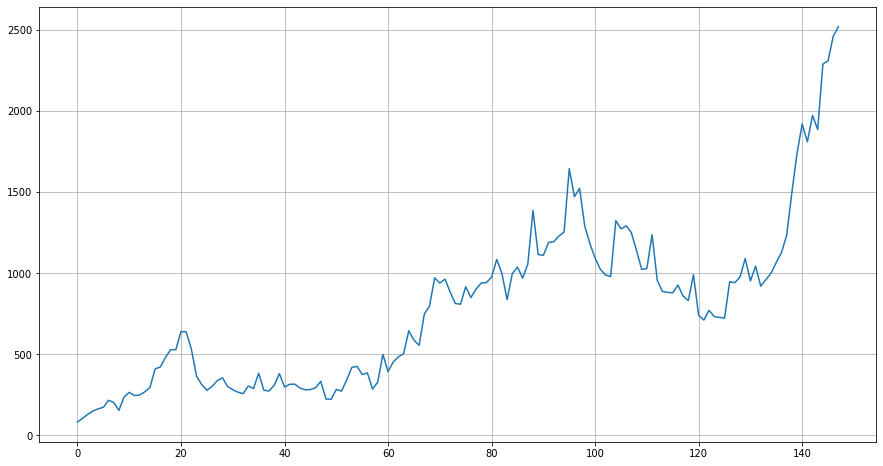

In [8]:
plt.figure(figsize=(15,8))
plt.plot(df_agg.index , df_agg.value_rub)
plt.grid(True)
df_agg.describe()

### Разбиение ряда на тренд и сезонность

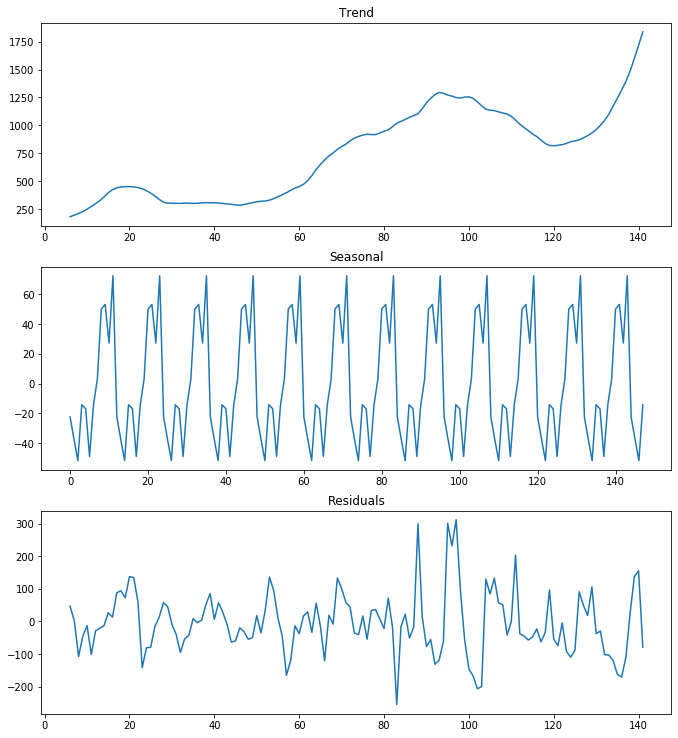

In [9]:
series = df_agg.value_rub
res = seasonal_decompose(series, freq = 12)

fig, (ax1,ax2,ax3) = plt.subplots(3,1, figsize=(10,8))
res.trend.plot(ax=ax1)
res.seasonal.plot(ax=ax2)
res.resid.plot(ax=ax3)

ax1.set_title('Trend')
ax2.set_title('Seasonal')
ax3.set_title('Residuals')
plt.subplots_adjust(bottom=0.3, right=1, top=1.5)
plt.show()

### Ручной подбор параметра d для SARIMAX, проверка на станционарность

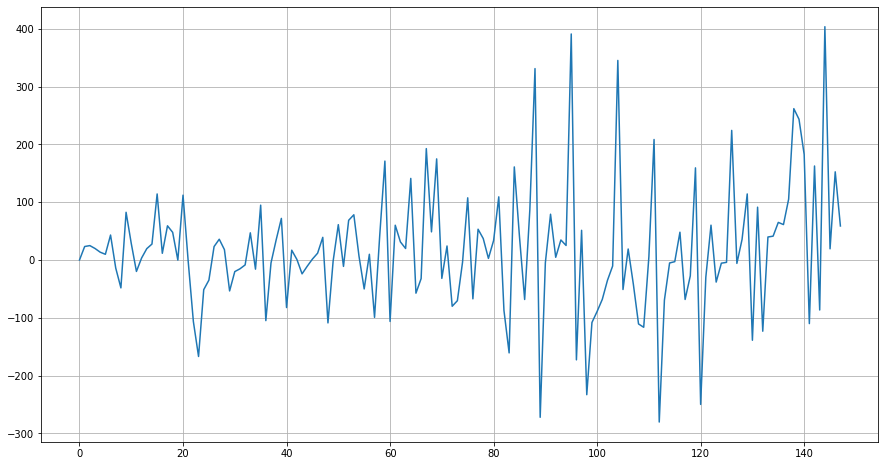

In [10]:
#Дифференцируем ряд
df_agg['diff_1'] = df_agg.value_rub.diff(periods=1).fillna(0)
plt.figure(figsize=(15,8))
plt.grid(True)
plt.plot(df_agg.index , df_agg.diff_1)

In [11]:
print(f' Исходный ряд : {is_stationary(df_agg.value_rub)} , диф. ряд : {is_stationary(df_agg.diff_1)}')

 Исходный ряд : False , диф. ряд : True


### Кросс-валидация SARIMAX

In [12]:
def sarima_params(seasonal=[0]):
    param_list = list()
    p_params = [0, 1, 2]
    d_params = [1] #тк ряд станционарен при d=1 (см. выше)
    q_params = [0, 1, 2]
    t_params = ['n','c','t','ct']
    P_params = [0, 1, 2]
    D_params = [0, 1]
    Q_params = [0, 1, 2]
    m_params = seasonal
    for p in p_params:
        for d in d_params:
            for q in q_params:
                for t in t_params:
                    for P in P_params:
                        for D in D_params:
                            for Q in Q_params:
                                for m in m_params:
                                    params = [(p,d,q), (P,D,Q,m), t]
                                    param_list.append(params)
    return param_list

param_list = sarima_params(seasonal=[12])

print(f'Мощность кросс-валидации =  {len(param_list)}')

Мощность кросс-валидации =  648


In [13]:
#Данные
values = df_agg['value_rub']
train = values[:-11]
test = values[-12:]

In [14]:
best_mape = np.inf
best_config = []
failures = 0

for j in tqdm(range(len(param_list))):
    (p,d,q), (P,D,Q,m),t = param_list[j]
    
    try: #Бывают странные оишбки, не было время особо разбираться :) 
        model = SARIMAX(train, order=(p,d,q), seasonal_order=(P,D,Q,m), trend = t)
        model_fit = model.fit()
    except:
        failures += 1
        continue

    y_forecast = model_fit.forecast(len(test))
    mape = mean_absolute_percentage_error(np.array(test),np.array(y_forecast))
    if mape < best_mape:
        best_mape = mape
        best_params = (p,d,q), (P,D,Q,m), t


        
print(f'Failures occured: {failures} / {len(param_list)}')

100%|████████████████████████████████████████████████████████████████████████████████| 648/648 [11:09<00:00,  1.03s/it]

Failures occured: 0 / 648


Best params are: ((0, 1, 0), (0, 1, 0, 12), 'ct')
Best MAPE  = 21.860420293746085


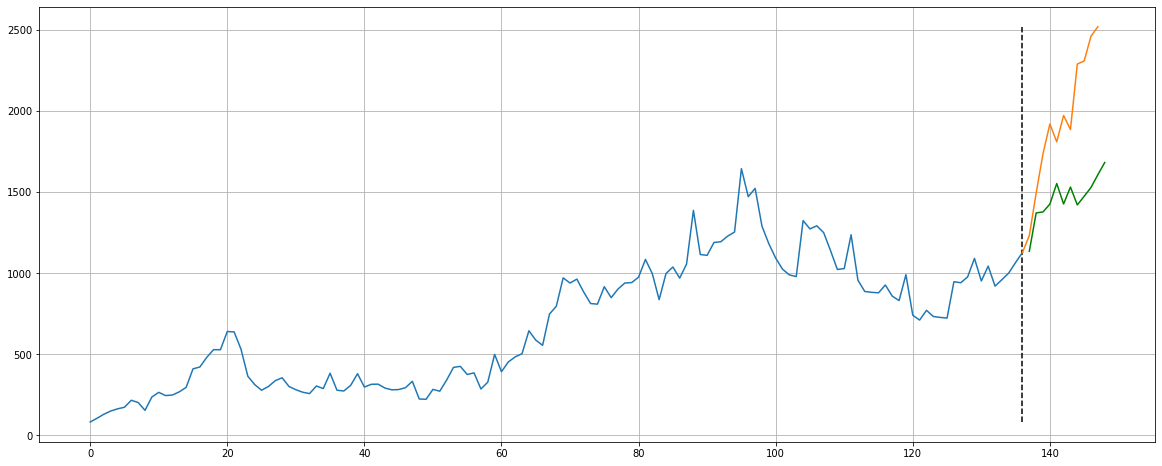

In [15]:
# Тест
print(f'Best params are: {best_params}')

(p,d,q), (P,D,Q,m), t = best_params

best_model = SARIMAX(train, order=(p,d,q), seasonal_order=(P,D,Q,m), trend = t)
best_model_fit  = best_model.fit()
pred = best_model_fit.forecast(len(test))        
print(f'Best MAPE  = {best_mape}')

plt.figure(figsize=(20,8))
plt.grid(True)
plt.plot(train)
plt.plot(test)
plt.vlines(len(train)-1, ymin=min(train), ymax=max(test), linestyles='dashed')
plt.plot(pred, color='green')
plt.show()

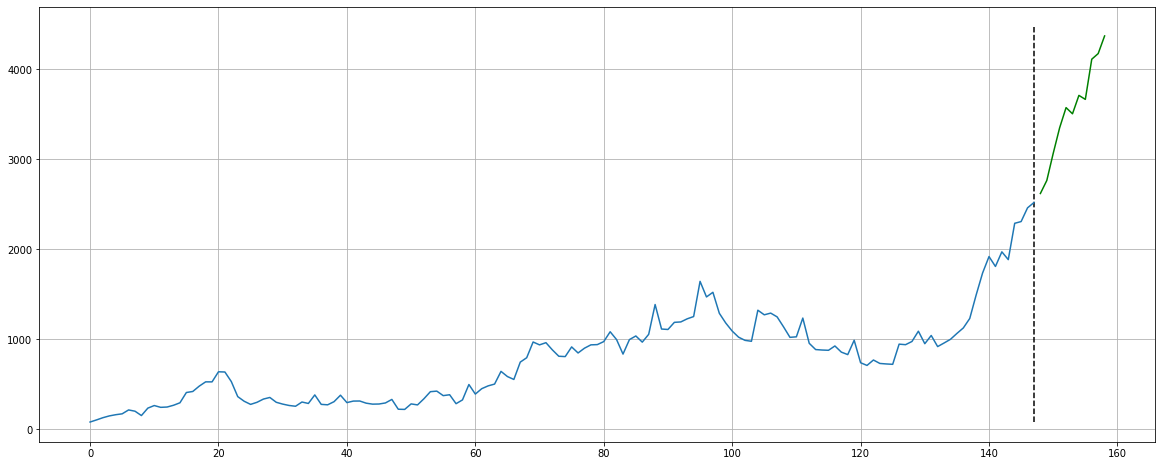

In [16]:
# Год вперед
model = SARIMAX(values, order=(p,d,q), seasonal_order=(P,D,Q,m), trend = t)
model_fit = model.fit()
pred_next_year = model_fit.forecast(12)


plt.figure(figsize=(20,8))
plt.grid(True)
plt.plot(values)
plt.vlines(len(values)-1, ymin=min(values), ymax=max(pred_next_year), linestyles='dashed')
plt.plot(pd.Series(pred_next_year, index = range(values.index[-1], values.index[-1] + 12, 1)), color='green')
plt.show()

### Эксп. сглаживания, Holt-Winters

In [17]:
values = df_agg['value_rub']
train = values[:-11]
test = values[-12:]

In [18]:
#Кросс-валидация

def exp_smoothing_params(seasonal=[None]):
    models = list()
    # define config lists
    t_params = ['add', 'mul', None]
    d_params = [True, False]
    s_params = ['add', 'mul', None]
    p_params = seasonal
    b_params = [True, False]
    r_params = [True, False]
    # create config instances
    for t in t_params:
        for d in d_params:
            for s in s_params:
                for p in p_params:
                    for b in b_params:
                        for r in r_params:
                            cfg = [t,d,s,p,b,r]
                            models.append(cfg)
    return models

param_list = exp_smoothing_params(seasonal=[12])

print(f'Мощность кросс-валидации =  {len(param_list)}')

Мощность кросс-валидации =  72


In [19]:
# Подбор параметров
best_mape = np.inf
best_config = []

for j in tqdm(range(len(param_list))):

    params = param_list[j]
    t,d,s,p,b,r = params
    
    if (t == None):
        model = ExponentialSmoothing(train, trend=t, seasonal=s, seasonal_periods=p)
    else:
        model = ExponentialSmoothing(train, trend=t, damped=d, seasonal=s, seasonal_periods=p)

    model_fit = model.fit(optimized=True, use_boxcox=b, remove_bias=r)

    y_forecast = model_fit.forecast(len(test))
    mape = mean_absolute_percentage_error(test,y_forecast)

    if mape < best_mape:
        best_mape = mape
        best_config = param_list[j]

100%|██████████████████████████████████████████████████████████████████████████████████| 72/72 [00:28<00:00,  2.49it/s]


Best config is: ['mul', True, 'add', 12, True, False]
Best MAPE  = 29.64586564611032


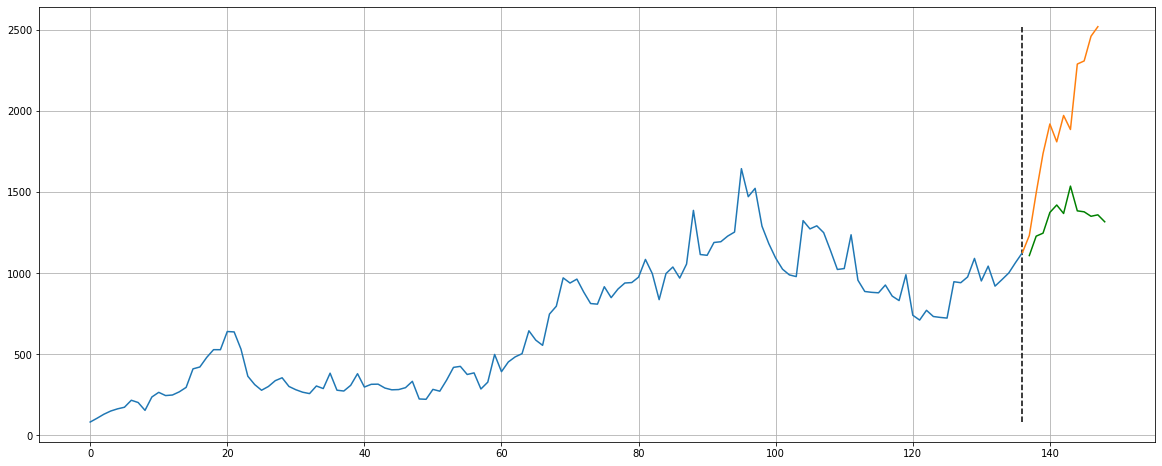

In [20]:
#Тест
print(f'Best config is: {best_config}')
t,d,s,p,b,r = best_config

best_model = ExponentialSmoothing(train, trend=t, damped=d, seasonal=s, seasonal_periods=p)
hw_model  = best_model.fit(optimized=True, use_boxcox=b, remove_bias=r)
pred = hw_model.forecast(len(test))        
print(f'Best MAPE  = {best_mape}')

plt.figure(figsize=(20,8))
plt.grid(True)
plt.plot(train)
plt.plot(test)
plt.vlines(len(train)-1, ymin=min(train), ymax=max(test), linestyles='dashed')
plt.plot(pred, color='green')
plt.show()

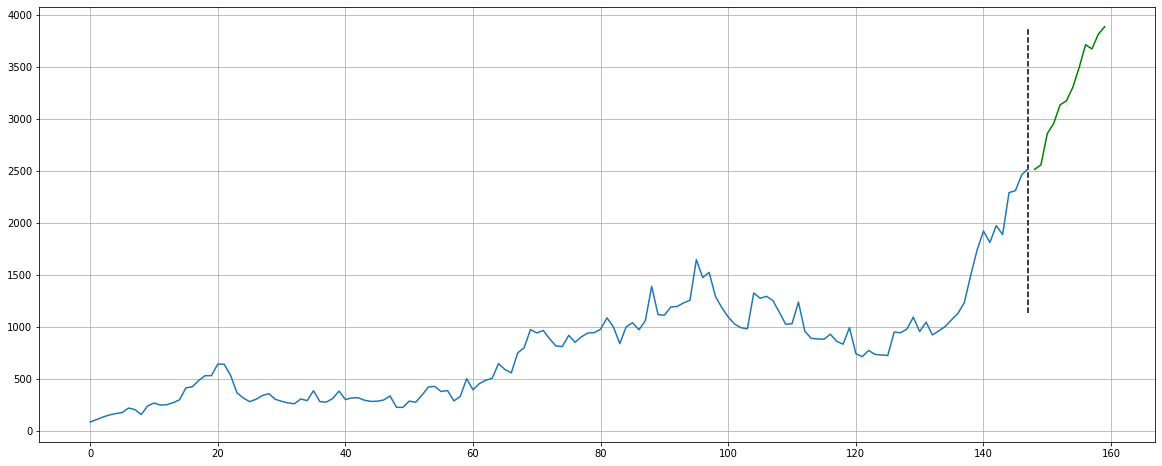

In [21]:
# Год вперед
best_model = ExponentialSmoothing(values, trend=t, damped=d, seasonal=s, seasonal_periods=p)
hw_model  = best_model.fit(optimized=True, use_boxcox=b, remove_bias=r)
pred_next_year = hw_model.forecast(12)

plt.figure(figsize=(20,8))
plt.grid(True)
plt.plot(values)
plt.vlines(len(values)-1, ymin=min(test), ymax=max(pred_next_year), linestyles='dashed')
plt.plot(pred_next_year, color='green')
plt.show()